# **\[PyG\]** lesson5: Learning Methods on Graphs

신록예찬  
2023-08-27

# **\[PyG\]** lesson5: Learning Methods on Graphs

# Download notebook

``` default
!wget https://raw.githubusercontent.com/miruetoto/yechan3/main/posts/2_Studies/PyG/ls5.ipynb
```

# Ref

-   <https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html>

# data

Cora 데이터셋은 컴퓨터 과학 관련 학술 논문에 대한 정보를 포함하고 있는
그래프 데이터셋입니다. 이 데이터셋은 주로 그래프 신경망(Graph Neural
Network, GNN) 모델의 성능을 평가하기 위한 벤치마크 데이터셋으로
사용됩니다. 아래는 Cora 데이터셋에 대한 설명입니다:

1.  그래프 구조: Cora 데이터셋은 학술 논문 간의 인용 관계를 그래프로
    나타냅니다. 각 논문은 그래프의 노드로 표현되며, 인용된 논문 간에
    에지(엣지)가 형성됩니다. 이로써 논문 간의 연결 관계가 고려된 그래프
    구조를 갖고 있습니다.

2.  노드 특성: 각 논문 노드는 해당 논문의 주제에 관련된 특성 정보를
    가지고 있습니다. 이 특성 정보는 논문의 텍스트를 분석하여 추출한
    것으로, 단어 또는 단어의 임베딩 벡터로 표현됩니다. 따라서 노드
    특성은 논문의 주제나 내용에 대한 정보를 나타냅니다.

3.  클래스 레이블: 각 논문 노드는 학술 분야(class)에 따라 클래스
    레이블로 레이블링되어 있습니다. 총 7개의 학술 분야로 나누어지며, 각
    논문은 해당 분야에 속합니다. 클래스 레이블은 논문을 다른 학술 분야로
    분류하는 데 사용됩니다.

4.  목적: Cora 데이터셋은 논문 분류 및 예측을 위한 목적으로 사용됩니다.
    주어진 논문의 노드 특성과 인용 관계를 기반으로, 어떤 학술 분야에
    속하는지 예측하거나 논문을 분류하는 작업에 활용됩니다.

Cora 데이터셋은 그래프 신경망 모델을 학습하고 평가하는 데 널리 사용되며,
그래프 분류 문제와 그래프 관련 기술을 연구하는 데 유용한 예시 데이터셋
중 하나입니다.

In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!

In [2]:
dataset[0] 

In [3]:
type(dataset[0])

In [5]:
import torch_geometric

In [6]:
torch_geometric.data.Data

In [7]:
dataset[0].edge_index.shape

In [8]:
dataset[0].y.dtype

In [11]:
dataset[0].train_mask

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # train에 대한 loss만 따로 처리해야함
    loss.backward()
    optimizer.step()

In [25]:
out.shape # 카테고리가 7개

In [28]:
data.y.unique() # 카테고리가 7개

In [29]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum() # 애큐러시는 test
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7950

# FRAUD data에 활용?

1.  고객정보별로 그래프생성
2.  커다란 하나의 그래프 생성

# model 분석

In [30]:
model

In [31]:
dataset.data

/home/jy/anaconda3/envs/torch/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)

-   2708개의 노드가 있음 $\to$ 이걸 observation으로 해석해야함.
-   각 노드에는 1433개의 특징(X)과 0-6까지의 label(y)이 연결되어 있음.
-   2708개의 노드는 각각 tr,val,test로 나누어짐

In [32]:
b,W = list(model.conv1.parameters())

In [33]:
W,W.shape # 1433개의 특징을 16개로 줄임

In [34]:
b,b.shape

# GCNConv?? Kipf and Welling (2016)

-   ref:
    <https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html>

아래의 논문에서 제안되었음.. (레퍼수가..)

<https://arxiv.org/abs/1609.02907>

대략적인 설명을 캡쳐하면 아래와 같음

<figure class="margin-caption">
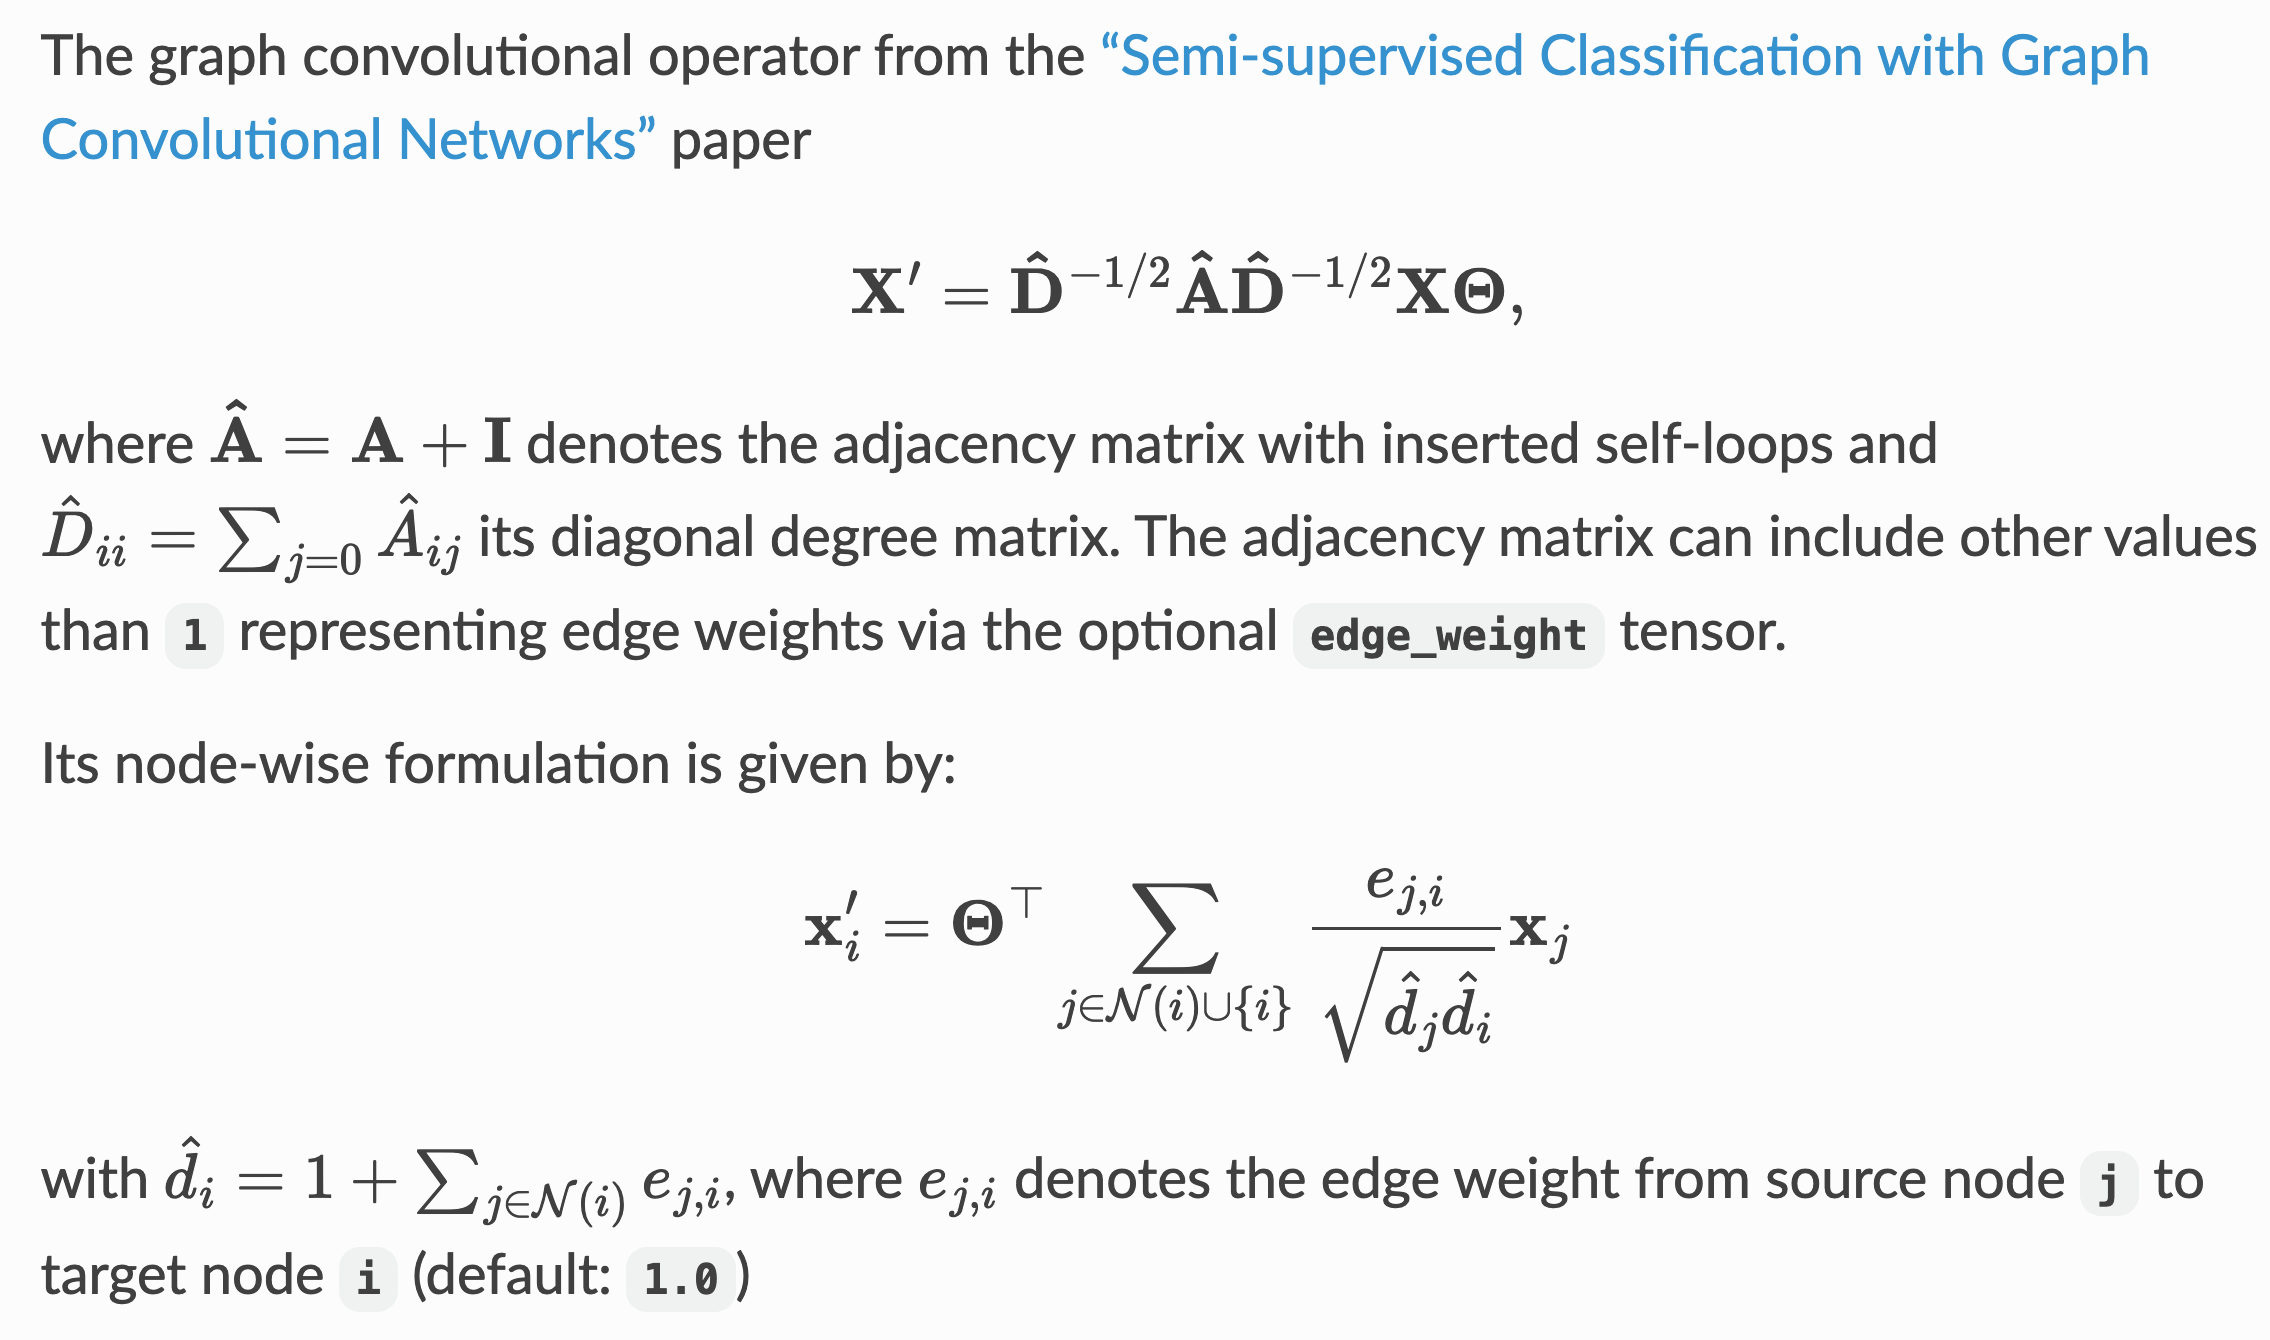
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

여기에서

1.  ${\bf A}$는 연결정보를 의미
2.  $\hat{\bf A}$는 연결정보에 자기자신의 노드를 추가
3.  ${\bf D}$는 ${\bf A}$를 표준화하기 위한 매트릭스
4.  결국 $\hat{\bf D}^{-1/2}\hat{\bf A}\hat{\bf D}^{-1/2}$ 는 통째로
    연결정보에 대한 matrix
5.  $\hat{\bf D}^{-1/2}\hat{\bf A}\hat{\bf D}^{-1/2}{\bf X}$ 는 통째로
    ${\bf X}$를 평행이동한것을 의미 (혹은 그 비슷한 것을 의미)
6.  ${\bf \Theta}$는 weight를 곱하는 과정임

Kipf, Thomas N, and Max Welling. 2016. “Semi-Supervised Classification
with Graph Convolutional Networks.” *arXiv Preprint arXiv:1609.02907*.